In [46]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches as patches

In [47]:
# create a dataset with 5 clusters and 2 features
data1=np.array([np.ones(1000)*1,np.ones(1000)*2,np.ones(1000)*(-1)])
data2=np.array([np.ones(1000)*(-1),np.ones(1000)*3,np.ones(1000)*(-2)])
data=np.hstack((data1, data2))
data=(data + np.random.rand(3,2000)*0.2)

In [48]:
# create map dimension
network_dimensions = np.array([5, 1])
iterations = 1000
learning_rate = 0.5
#normalize data
normalize_data = True
# if True, assume all data on common scale
# if False, normalise to [0 1] range along each column
normalize_by_column = False
# establish variables based on data
col = data.shape[0]
row = data.shape[1]

In [49]:
# initial neighbourhood radius
radius = 1
# radius decay parameter
time_constant = iterations / np.log(radius)
# check if data needs to be normalised
if normalize_data:
    if normalize_by_column:
        # normalize along each column
        col_max = data.max(axis=0)
        data = data / col_max[np.newaxis, :]
    else:
        # normalize entire dataset
        data = (data-data.min()) / (data.max()-data.min())

C:\Users\Albert\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


In [50]:
# setup weight matrix
clust= np.array([[[1.,1.,-1.]],
       [[2.,1.,1.]],
       [[-1.,2.,-3.]],
       [[1.,2.,3.]],
       [[1.,1.,3.]]])

In [51]:
def find_bmu(train, clust, col):
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    min_dist = np.iinfo(np.int).max    
    # calculate the high-dimensional distance between each neuron and the input
    for x in range(clust.shape[0]):
        for y in range(clust.shape[1]):
            w = net[x, y, :].reshape(col, 1)
            # don't bother with actual Euclidean distance, to avoid expensive sqrt operation
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # get vector corresponding to bmu_idx
    bmu = clust[bmu_idx[0], bmu_idx[1], :].reshape(col, 1)
    # return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)


In [52]:
def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

In [53]:
def decay_learning_rate(learning_rate, i, iterations):
    return learning_rate * np.exp(-i / iterations)

In [54]:
def calculate_influence(distance, radius):
    return np.exp(-distance / (2* (radius**2)))

In [61]:
for i in range(iterations):
    # select a training example at random
    t = data[:, np.random.randint(0, row)].reshape(np.array([col, 1]))
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, clust, col)
    # decay the SOM parameters
    rang = decay_radius(radius, i, time_constant)
    learn = decay_learning_rate(learning_rate, i, iterations)
    # now we know the BMU, update its weight vector to move closer to input
    # and move its neighbours in 2-D space closer
    # by a factor proportional to their 2-D distance from the BMU
    for x in range(clust.shape[0]):
        for y in range(clust.shape[1]):
            weight = clust[x, y, :].reshape(col, 1)
            # get the 2-D distance (again, not the actual Euclidean distance)
            weight_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            # if the distance is within the current neighbourhood radius
            if weight_dist <= r**2:
                # calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(weight_dist, rang)
                # now update the neuron's weight using the formula:
                # new w = old w + (learning rate * influence * delta)
                # where delta = input vector (t) - old w
                new_weight = weight + (learn * influence * (t - weight))
                # commit the new weight
                clust[x, y, :] = new_w.reshape(1, 3)

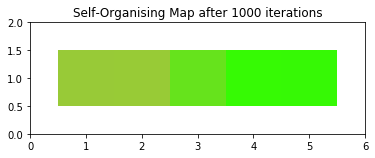

In [64]:
fig = plt.figure()
# setup axes
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((0, clust.shape[0]+1))
ax.set_ylim((0, clust.shape[1]+1))
ax.set_title('Self-Organising Map after %d iterations' % iterations)
# The Plot can be seen asa compression of the 3000x3 dataset into a 5x5x3 map
# plot the rectangles
for x in range(1, clust.shape[0] + 1):
    for y in range(1, clust.shape[1] + 1):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                     facecolor=net[x-1,y-1,:],
                     edgecolor='none'))
plt.show()